In [1]:
import pystan
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy.optimize import curve_fit

# Pystan and Purpose:

These notes are meant to serve as a playground for me to familiarize myself with PySTAN module and ultimately serve as a way for me to estimate the strength, and possibly the locus of the drive allele. Stan is a modelling tool that is essentially a programming language. Pystan is an intepreter for this language that allows us to implement stan in a python shell. 

Stan will allow me to use a Bayesian approach to modelling parameter estimates. It implements NUTS and MCMC to estimate the parameters of a given function.

## Learning Stan:

Going to play around with the examples.

In [2]:
schools_code = """
data {
    int<lower=0> J; // number of schools
    vector[J] y; // estimated treatment effects
    vector<lower=0>[J] sigma; // s.e. of effect estimates
}
parameters {
    real mu;
    real<lower=0> tau;
    vector[J] eta;
}
transformed parameters {
    vector[J] theta;
    theta = mu + tau * eta;
}
model {
    eta ~ normal(0, 1);
    y ~ normal(theta, sigma);
}
"""

schools_dat = {'J': 8,
               'y': [28,  8, -3,  7, -1,  1, 18, 12],
               'sigma': [15, 10, 16, 11,  9, 11, 10, 18]}



In [3]:
sm = pystan.StanModel(model_code=schools_code)
fit = sm.sampling(data=schools_dat, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_19a09b474d1901f191444eaf8a6b8ce2 NOW.


We have now fitted parameters to our model and im going to extract a posterior distribution.

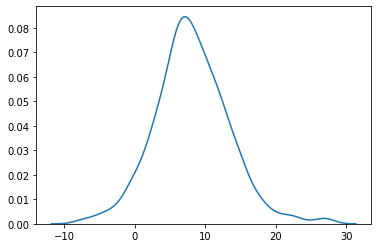

In [4]:
sns.kdeplot(fit.extract()['mu'])

## Application:

The easiest way I can start to apply this is to use for the estimation of my drive strength and drive locus parameter for segregation distortion detection. Currently, I am using a curve fitting non-linear least squares regression, which in theory should work, but seems to be giving me inaccurate drive strength estimation. My hope is that using STAN will give me a superior estimate of the parameters. 

In addition to the decay rate mapping another good thing to estimate would be the underlying process by which the allele frequencies were generated. This is a bit more complicated however so I'll leave it for later. Getting this modelling right though may help me in fitting my allele freq decay model so I shouldn't eliminate that this may be playing a role.

In [22]:
def expect_AF(cM, D, drive_locus):
    """
    Calculate our expected allele frequencies given a drive locus on our chr3
    """
   
    P_drive = .5 + D
    P_odd = (lambda x: (1-math.exp(-( (2*x) / 100 ) )) / 2)
    E_p1 = (lambda x:.5*( P_drive * (1-x) + (1-P_drive)*x) + .5)
    distance = abs(cM - drive_locus)
    CO_prob = np.array(list(map(P_odd, distance)))
    E_AF = 1-np.array(list(map(E_p1, CO_prob)))
            
    
    
   
        
    return E_AF

def cM_map(arm):
    """
    The function to map a bp coordinate to cM coordinate
    Use this function to create maps

    :param x:
    :return:
    """
    
    chr_2L = (lambda x: -0.01*x**3 + 0.2*x**2 + 2.59*x - 1.59)
    chr_2R = (lambda x: -0.007*x**3 + 0.35*x**2 - 1.43*x + 56.91)
    chr_3L = (lambda x: -0.006*x**3 + 0.09*x**2 + 2.94*x - 2.9)
    chr_3R = (lambda x:-0.004*x**3 + 0.24*x**2 - 1.63*x + 50.26)
    chr_X = (lambda x: -0.01*x**3 + 0.30*x**2 + 1.15*x - 1.87)
    
    bp_to_cM = [chr_2L, chr_2R, chr_3L, chr_3R, chr_X]
 
    return bp_to_cM[arm]

def simDrive(big):
    heterochromatin = {
        #A map of the freely recombining intervals of euchromatin within each drosophila chromosome arm in Mb
            0: (0.53, 18.87),
            1: (1.87, 20.87),
            2:(0.75, 19.02),
            3:(2.58, 27.44),
            4:(1.22, 21.21)
        }
    L = big[0][np.intersect1d(np.where(big[0][:,0] < heterochromatin[0][1]), np.where(big[0][:,0] > heterochromatin[0][0]))]
    R = big[0][np.intersect1d(np.where(big[0][:,0] < heterochromatin[1][1]+23), np.where(big[0][:,0] > heterochromatin[1][0]+23))]
    pos_2 = np.concatenate((L, R))
    cmL = np.array(list(map(cM_map(0), L[:,0])))
    cmR = np.array(list(map(cM_map(1), R[:,0] - 23)))

    chr2_transformed = np.vstack((np.concatenate((L[:,1], R[:,1])) ,np.concatenate((cmL, cmR)))).T
    
    alleleFreq = expect_AF(cM = chr2_transformed[:,1], D=.1, drive_locus=57)
    noisyAF = np.random.binomial(n=np.full(shape=(len(alleleFreq)), fill_value = 2000), p=alleleFreq) / 2000
    
    return noisyAF

def fit_data(data, big):
    heterochromatin = {
        #A map of the freely recombining intervals of euchromatin within each drosophila chromosome arm in Mb
            0: (0.53, 18.87),
            1: (1.87, 20.87),
            2:(0.75, 19.02),
            3:(2.58, 27.44),
            4:(1.22, 21.21)
        }

    L = big[0][np.intersect1d(np.where(big[0][:,0] < heterochromatin[0][1]), np.where(big[0][:,0] > heterochromatin[0][0]))]
    R = big[0][np.intersect1d(np.where(big[0][:,0] < heterochromatin[1][1]+23), np.where(big[0][:,0] > heterochromatin[1][0]+23))]
    pos_2 = np.concatenate((L, R))
    cmL = np.array(list(map(cM_map(0), L[:,0])))
    cmR = np.array(list(map(cM_map(1), R[:,0] - 23)))
    chr2_transformed = np.vstack((np.concatenate((L[:,1], R[:,1])) ,np.concatenate((cmL, cmR)))).T
    
    fit_params, pcov = curve_fit(expect_AF, chr2_transformed[:,1], data)
    predict_af = expect_AF(cM= chr2_transformed[:,1], D = fit_params[0], drive_locus=fit_params[1])
    print(fit_params)
    sns.scatterplot(pos_2[:,0], data, alpha = .1, edgecolor=None, color='black')
    plt.plot(pos_2[:,0], predict_af, linestyle='--', color='red')
    plt.show()
    plt.close()

def calcAF(af):
    
    genome = [np.concatenate((af[0][0][:, 0], af[0][1][:, 0] + 23000000)) / 1000000,
                                np.concatenate((af[0][2][:, 0], af[0][3][:, 0] + 24500000)) / 1000000,
                                af[0][4][:, 0] / 1000000]
    
    SNP_pileup = [[],[],[]]
    for cell in af:
        
        if len(SNP_pileup[0]) == 0:
            SNP_pileup[0] = np.concatenate((cell[0][:,1], cell[1][:,1]))
        else:
            SNP_pileup[0] = np.vstack((SNP_pileup[0], np.concatenate((cell[0][:,1], cell[1][:,1]))))
        
        if len(SNP_pileup[1]) == 0:
            SNP_pileup[1] = np.concatenate((cell[2][:,1], cell[3][:,1]))
        else:
            SNP_pileup[1] = np.vstack((SNP_pileup[1], np.concatenate((cell[2][:,1], cell[3][:,1]))))
        
        if len(SNP_pileup[2]) == 0:
            SNP_pileup[2] = cell[4][:,1]
        else:
            SNP_pileup[2] = np.vstack((SNP_pileup[2],  cell[4][:,1]))

    for arm in range(3):
        genome[arm] = np.vstack((genome[arm], np.sum(SNP_pileup[arm], axis=0) / (len(af)))).T
        
        #np.vstack((genome[arm], SNP_pileup[arm])).T 
    
    return genome


def sparse_parse(input_array):
        
    af = np.load(input_array, allow_pickle=True)  
    genome = [np.concatenate((af[0][0][:, 0], af[0][1][:, 0] + 23000000)) / 1000000,
                                np.concatenate((af[0][2][:, 0], af[0][3][:, 0] + 24500000)) / 1000000,
                                af[0][4][:, 0] / 1000000]
    
    SNP_pileup = [[],[],[]]
    for cell in af:
        
        if len(SNP_pileup[0]) == 0:
            SNP_pileup[0] = np.concatenate((cell[0][:,1], cell[1][:,1]))
        else:
            SNP_pileup[0] = np.vstack((SNP_pileup[0], np.concatenate((cell[0][:,1], cell[1][:,1]))))
        
        if len(SNP_pileup[1]) == 0:
            SNP_pileup[1] = np.concatenate((cell[2][:,1], cell[3][:,1]))
        else:
            SNP_pileup[1] = np.vstack((SNP_pileup[1], np.concatenate((cell[2][:,1], cell[3][:,1]))))
        
        if len(SNP_pileup[2]) == 0:
            SNP_pileup[2] = cell[4][:,1]
        else:
            SNP_pileup[2] = np.vstack((SNP_pileup[2],  cell[4][:,1]))

    for arm in range(3):
        #To account for the nans we must not divide by the total number of cells but by the number of SNPs
        #Seeen at that position
        
        tot_SNPs = abs(np.sum(np.isnan(SNP_pileup[arm]).astype(int), axis=0) - len(af))
        
        genome[arm] = np.vstack((genome[arm], np.nansum(SNP_pileup[arm], axis=0) / tot_SNPs)).T
        
        #np.vstack((genome[arm], SNP_pileup[arm])).T 
    
    return genome

def plot_mAF(genome):
    
    chromosomes = ['Chr2', 'Chr3', 'ChrX']
    with sns.axes_style('whitegrid'):
        fig = plt.figure(figsize=(15, 10))
        axs = fig.subplots(3)
        for p in range(3):
            sns.scatterplot(genome[p][:, 0], genome[p][:, 1], ax=axs[p], alpha=.1, edgecolor=None)
            axs[p].set_title(chromosomes[p])
            axs[p].set_ylabel('P2 AF')
    axs[2].set_xlabel('Mb')
    plt.tight_layout()
    #plt.savefig('{0}.png'.format(name), dpi=300)
    plt.show()
    plt.close()

[ 0.09969329 56.70366793]


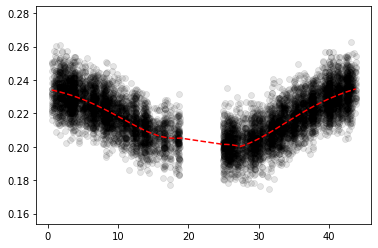

In [25]:
data = np.load('/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/simData.npy', allow_pickle=True)
af_data = calcAF(data)
noisy_data = simDrive(big=af_data)
fit_data(noisy_data, big=af_data)

Here is my model fitting under my NLLS approach which works great on this particular simulated data, but not under data that I take from my single cell simulation.

Now let's try and see if I can't construct a Stan model to estimate these parameters. Firstly, I need to determine some priors for the distributions of the parameters:

## Drive strength:

This parameter should be distributed with most of the density on the 0 and then equal weight on either side of the distribution w/ a maximum strength of +/- 0.5. The majority of the weight should be around +/- .1 of the mean. I would guess that it is normal-ish distributed

## Driver locus:

The location of the driver parameter is also bounded, but in this case bounded by the length of the chromosome in cM. Each chromosome has a different prior distribution, but the shapes should be similar. I imagine that my prior distribution here weighs heavily near the centromere. Perhaps with some density near the telomeres.